In [1]:
import csv
import numpy as np
import random
import math

import json
import pickle

from glob import glob
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable

from sklearn import manifold, datasets, decomposition
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D plot need this library, can't remove

from torchsummary import summary

In [2]:
# # cuda setting
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
torch.cuda.set_device(1)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

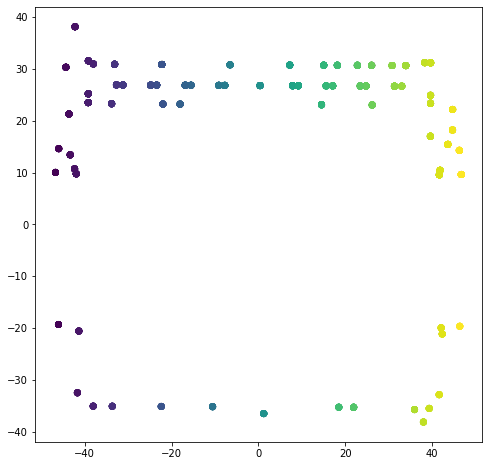

In [3]:
pos_data_origin = np.load("np_data/floor_num_2/pos_train.npy")
rssi_data = np.load("np_data/floor_num_2/RSSI_train.npy")
rssi_data = np.round_((rssi_data / 110 + 1) * 100) / 100

a, b = 20, 11

pos_data_x = (pos_data_origin[:, :1] * a - pos_data_origin[:, 1:] * b) / ((a**2 + b**2)**0.5)
pos_data_y = (pos_data_origin[:, :1] * b + pos_data_origin[:, 1:] * a) / ((a**2 + b**2)**0.5)
pos_data = np.concatenate((pos_data_x, pos_data_y), axis=1)
pos_data = pos_data - ((pos_data.max(axis=0) + pos_data.min(axis=0)) / 2)

ccm = np.array(pos_data[:, 0] + pos_data[:, 0])
# ccm = np.array(pos_data[:, 0] + pos_data[:, 1])

ccm = ((ccm - ccm.min()) / (ccm.max() - ccm.min()) * 200 + 25).astype(np.int32)

plt.figure(figsize=(8, 8))
plt.scatter(pos_data[:, 0], pos_data[:, 1], c=ccm)
plt.show()

In [4]:
# get pos_fake data
random_arr = np.arange(len(pos_data))
np.random.shuffle(random_arr)
pos_fake_data = pos_data[random_arr]

pos_tensor = torch.from_numpy(pos_data).float().cuda()
pos_fake_tensor = torch.from_numpy(pos_fake_data).float().cuda()

while True:
    dis_tensor = torch.sqrt(torch.sum((pos_tensor - pos_fake_tensor)**2, dim=1))
    OuO = torch.where(dis_tensor <= 10)[0]
    if len(OuO) == 0: break
    
    random_arr = np.arange(len(pos_data))
    np.random.shuffle(random_arr)
    
    pos_fake_tensor[OuO] = pos_tensor[random_arr][OuO]
    print(OuO)
    
print("OuO")
pos_fake_data = pos_fake_tensor.cpu().numpy()
sample_index = np.random.randint(len(pos_data))
show_len = 20
pos_data.shape, pos_fake_data.shape

tensor([  85,  118,  152,  195,  198,  210,  219,  220,  222,  233,  237,  242,
         259,  267,  285,  296,  300,  305,  307,  309,  311,  319,  339,  348,
         350,  353,  360,  383,  384,  387,  390,  401,  406,  414,  434,  440,
         442,  451,  458,  460,  467,  468,  473,  491,  498,  515,  518,  519,
         522,  533,  539,  542,  556,  563,  565,  582,  601,  606,  608,  616,
         620,  626,  628,  630,  639,  645,  658,  661,  664,  673,  707,  708,
         713,  714,  719,  722,  727,  744,  756,  758,  761,  765,  775,  782,
         783,  786,  792,  795,  796,  804,  806,  814,  816,  845,  849,  853,
         861,  875,  882,  883,  893,  901,  903,  919,  922,  933,  940,  941,
         945,  946,  947,  965,  977,  979, 1000, 1003, 1009, 1011, 1035, 1050,
        1058, 1062, 1064, 1067, 1070, 1071, 1076, 1086, 1098, 1100, 1106, 1109,
        1111, 1114, 1124, 1135, 1141, 1142, 1143, 1155, 1167, 1171, 1183, 1194,
        1200, 1207, 1208, 1213, 1214, 12

((1577, 2), (1577, 2))

In [5]:
route_len = 20
step_num = 5

In [14]:
import json

# with open("route_data/UJI_all_pass_route_data_f2_balance_break.json", "r") as f:
#     temp_route_data = json.load(f)

temp_route_data = np.load("route_data/UJI_all_route_data.npy", allow_pickle=True)
random_arr = np.arange(len(temp_route_data))

np.random.shuffle(random_arr)
temp_route_data = [temp_route_data[rr] for rr in random_arr]

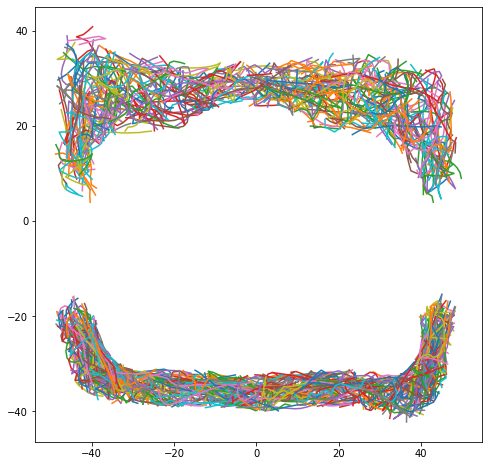

In [16]:
plt.figure(figsize=(8, 8))

for route in temp_route_data[:1000]:
    route = np.array(route)
    plt.plot(route[:, 0], route[:, 1])
plt.show()

(39534, 5, 2)


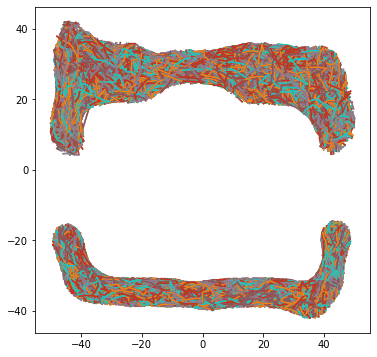

(1577, 16, 5, 2)

In [17]:
trajectory_pos_data = []

all_data_num = 1577
train_len = 1400
test_len = 177

for route in temp_route_data:
    if len(route) < step_num: continue
    
    route = np.array(route)[:step_num]
    trajectory_pos_data.append(route[:step_num])
    
    for step_i in range(len(route)-step_num+1):
        trajectory_pos_data.append(route[step_i:step_i+step_num])
    
# del temp_route_data
trajectory_pos_data = np.array(trajectory_pos_data)
trajectory_pos_data = trajectory_pos_data - ((trajectory_pos_data.max(axis=0) + trajectory_pos_data.min(axis=0)) / 2)
print(trajectory_pos_data.shape)

plt.figure(figsize=(6, 6))

for route in trajectory_pos_data:
    plt.plot(route[:, 0], route[:, 1])

plt.show()

trajectory_pos_data = trajectory_pos_data[:(all_data_num*(route_len-step_num+1))]
trajectory_pos_data = trajectory_pos_data.reshape(-1, route_len-step_num+1, step_num, 2)
trajectory_pos_data.shape

In [18]:
import pickle

with open('gpr_model/UJIindoorloc.pkl', 'rb') as f:
    gpr_model = pickle.load(f)

trajectory_num = trajectory_pos_data.shape[0]
trajectory_rssi_data = np.clip(gpr_model.predict(trajectory_pos_data.reshape(-1, 2)), 0, 1).reshape(trajectory_num, route_len-step_num+1, step_num, -1)

trajectory_rssi_data.shape

(1577, 16, 5, 80)

In [19]:
pos_data_origin = torch.from_numpy(pos_data).cuda()
rssi_data_origin = torch.from_numpy(rssi_data).cuda()

pos_data_tensor = pos_data_origin[0:1]
rssi_data_tensor = rssi_data_origin[0:1]

data_num = len(pos_data_origin)

for data_i in range(1, data_num):
    have_same_pos = False
    for temp_pos in pos_data_tensor:
        if torch.abs((pos_data_origin[data_i] - temp_pos)).sum() <= 0.05:
            have_same_pos = True
            break
            
    if have_same_pos: continue
    
    pos_data_tensor = torch.cat((pos_data_tensor, pos_data_origin[data_i:data_i+1]), dim=0)
    rssi_data_tensor = torch.cat((rssi_data_tensor, rssi_data_origin[data_i:data_i+1]), dim=0)

print(pos_data_tensor.shape, rssi_data_tensor.shape, pos_data_origin.shape, rssi_data_origin.shape)

pos_data_array = pos_data_tensor.cpu().detach().numpy()
rssi_data_array = rssi_data_tensor.cpu().detach().numpy()
AP = rssi_data_tensor.shape[1]

def find_neighbors_tensor(point_array):
    temp = torch.FloatTensor([]).cuda()
    
    point_array = point_array.reshape(-1, 2)
    for i in point_array:
        dis = torch.sum((i - pos_data_tensor)**2, dim=1)
        dis[dis==0] += 9999
        idx = torch.argsort(dis)
        neighbors_rssi = rssi_data_tensor[idx[:n]]
        neighbors_pos = pos_data_tensor[idx[:n]] - i
        neighbors_data = torch.cat((neighbors_pos, neighbors_rssi), dim=1).reshape(1, n, AP+2)
        
        temp = torch.cat((temp, neighbors_data), dim=0)
    
    temp = temp.float()
    return temp

torch.Size([73, 2]) torch.Size([73, 80]) torch.Size([1577, 2]) torch.Size([1577, 80])


In [20]:
neighbors_data = np.array([])

n = 4
neighbors_tensor = find_neighbors_tensor(pos_tensor)
neighbors_data = neighbors_tensor.cpu().detach().numpy()
neighbors_data.shape

(1577, 4, 82)

In [21]:
trajectory_pos_data_ = torch.from_numpy(trajectory_pos_data).float().cuda().reshape(-1, 2)
trajectory_pos_data = trajectory_pos_data.reshape(-1, route_len-step_num+1, step_num, 2)
trajectory_neighbors_data_ = find_neighbors_tensor(trajectory_pos_data_)
trajectory_neighbors_data = trajectory_neighbors_data_.reshape(-1, route_len-step_num+1, step_num, n, AP+2).cpu().detach().numpy()
trajectory_neighbors_data.shape

(1577, 16, 5, 4, 82)

In [22]:
pos_data.shape, rssi_data.shape, pos_fake_data.shape, neighbors_data.shape, trajectory_pos_data.shape, trajectory_rssi_data.shape, trajectory_neighbors_data.shape

((1577, 2),
 (1577, 80),
 (1577, 2),
 (1577, 4, 82),
 (1577, 16, 5, 2),
 (1577, 16, 5, 80),
 (1577, 16, 5, 4, 82))

In [23]:
random_arr = np.arange(len(pos_data))
np.random.shuffle(random_arr)

pos_data = pos_data[random_arr]
rssi_data = rssi_data[random_arr]
pos_fake_data = pos_fake_data[random_arr]
trajectory_pos_data = trajectory_pos_data[random_arr]
trajectory_neighbors_data = trajectory_neighbors_data[random_arr]
trajectory_rssi_data = trajectory_rssi_data[random_arr]
neighbors_data = neighbors_data[random_arr]

In [24]:
# all_data 2162
class C_I2APDataset(Dataset):
    def __init__(self, pos_data_train, real_data_train, pos_fake_data, trajectory_pos_data, trajectory_neighbors_data, trajectory_real_data, neighbors_data):
        self.pos_data_train = pos_data_train.astype(np.float32).copy()
        self.real_data_train = real_data_train.astype(np.float32).copy()
        self.pos_fake_data = pos_fake_data.astype(np.float32).copy()
        self.trajectory_pos_data = trajectory_pos_data.astype(np.float32).copy()
        self.trajectory_neighbors_data = trajectory_neighbors_data.astype(np.float32).copy()
        self.trajectory_real_data = trajectory_real_data.astype(np.float32).copy()
        self.neighbors_data = neighbors_data.astype(np.float32).copy()

    def __len__(self):
        return len(self.pos_data_train)

    def __getitem__(self, idx):
        return self.pos_data_train[idx], self.real_data_train[idx], self.pos_fake_data[idx], \
    self.trajectory_pos_data[idx], self.trajectory_neighbors_data[idx], self.trajectory_real_data[idx], self.neighbors_data[idx]

train_dataset = C_I2APDataset(pos_data[:train_len], rssi_data[:train_len], pos_fake_data[:train_len], trajectory_pos_data[:train_len], trajectory_neighbors_data[:train_len], trajectory_rssi_data[:train_len], neighbors_data[:train_len])
test_dataset  = C_I2APDataset(pos_data[train_len:], rssi_data[train_len:], pos_fake_data[train_len:], trajectory_pos_data[train_len:], trajectory_neighbors_data[train_len:], trajectory_rssi_data[train_len:], neighbors_data[train_len:])

batch_size = 700
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

test_d = next(iter(test_dataloader))
for i in range(len(test_d)): print(test_d[i].shape, end="")

torch.Size([177, 2])torch.Size([177, 80])torch.Size([177, 2])torch.Size([177, 16, 5, 2])torch.Size([177, 16, 5, 4, 82])torch.Size([177, 16, 5, 80])torch.Size([177, 4, 82])

In [25]:
class Generator(nn.Module):
    def __init__(self, v_dim, n):
        super().__init__()
        self.feature_fc1 = nn.Linear(AP+2, AP*2)
        self.feature_fc2 = nn.Linear(AP*2, int(AP*1.5))
        self.feature_fc3 = nn.Linear(int(AP*1.5), v_dim)
        
        self.pos_fc1 = nn.Linear(2, 512)
        self.pos_fc2 = nn.Linear(512, 128)
        
        self.generator_fc1 = nn.Linear(int(v_dim*n+128), int(AP*1.8))
        self.generator_fc2 = nn.Linear(int(AP*1.8), int(AP*1.2))
        self.generator_fc3 = nn.Linear(int(AP*1.2), AP)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def get_feature(self, neighbors_data):
        h1 = self.leaky_relu(self.feature_fc1(neighbors_data))
        h2 = self.tanh(self.feature_fc2(h1))
        feature = self.feature_fc3(h2)
        return feature
    
    def forward(self, neighbors_data, u):
        neighbors_data = neighbors_data.reshape(-1, AP+2)
        
        feature_data = self.get_feature(neighbors_data)
        feature_data = feature_data.reshape(-1, v_dim*n)
        feature_data = feature_data + torch.randn(feature_data.size()).cuda() * 0.005
        
        u = u + torch.randn(u.size()).cuda() * 0.1
        u_feature = self.pos_fc2(self.leaky_relu(self.pos_fc1(u)))
        feature_data = torch.cat((u_feature, feature_data), dim=1)
        
        h1 = self.leaky_relu(self.generator_fc1(feature_data))
        h2 = self.leaky_relu(self.generator_fc2(h1))
        reconstruction_rssi = self.sigmoid(self.generator_fc3(h2))
        return reconstruction_rssi

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(AP+2, AP+2)
        self.fc2 = nn.Linear(AP+2, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.D_out_layer = nn.Linear(64, 1)
        
        self.pos_out_layer1 = nn.Linear(64, 128)
        self.pos_out_layer2 = nn.Linear(128, 2)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h1 = self.leaky_relu(self.fc1(x))
        h2 = self.leaky_relu(self.fc2(h1))
        h3 = self.tanh(self.fc3(h2))
        h4 = self.leaky_relu(self.fc4(h3))
        h5 = self.leaky_relu(self.fc5(h4))
        
        out = self.sigmoid(self.D_out_layer(h5))
        u_I2AP = self.pos_out_layer2(self.tanh(self.pos_out_layer1(h5))) * 10
        return out, u_I2AP

In [27]:
class Make_seq(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(z_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 2*route_len)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        z1 = x
        z2 = torch.randn(x.shape[0], 1024).cuda()
        z3 = torch.randn(x.shape[0], 256).cuda()
        
        h1 = self.relu(self.fc1(z1)) + z2
        h2 = self.tanh(self.fc2(h1)) + z3
        out = self.fc3(h2).reshape(-1, route_len, 2) * 10
        return out

route_len = 20

In [28]:
class RouteDiscriminator(nn.Module):
    def __init__(self, step_num):
        super().__init__()
        self.fc1 = nn.Linear(step_num*AP, 128)
        self.fc2 = nn.Linear(128, 48)
        self.fc3 = nn.Linear(48, 1)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = inputs.reshape(-1, step_num*AP)
        h1 = self.relu(self.fc1(x))
        h2 = self.tanh(self.fc2(h1))
        out = (self.fc3(h2))
        return out

In [29]:
class ImuDiscriminator(nn.Module):
    def __init__(self, step_num):
        super().__init__()
        self.fc1 = nn.Linear(2*step_num-2, 128)
        self.fc2 = nn.Linear(128, 48)
        self.fc3 = nn.Linear(48, 1)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = inputs.reshape(-1, 2*step_num-2)
        h1 = self.relu(self.fc1(x))
        h2 = self.tanh(self.fc2(h1))
        out = (self.fc3(h2))
        return out

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)

In [31]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = torch.nn.BCELoss()
        self.l1_loss = torch.nn.L1Loss()
    
    def forward(self, generated_output, generated_rssi, gt):
#         x_temp = gt.reshape(-1, AP)
#         x_idx = x_temp != 0
#         rssi_loss = self.l1_loss(generated_rssi[x_idx], gt[x_idx])

        rssi_loss = (((generated_rssi - gt)**2) * (gt + 0.5)).mean() * 10000
#         rssi_loss = (torch.abs(generated_rssi - gt) * (gt + 0.5)).mean() * 1000
        div_loss = self.bce_loss(generated_output, torch.ones_like(generated_output).cuda())
        
        total_loss = rssi_loss + div_loss
        
        return total_loss, rssi_loss, div_loss

In [32]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = torch.nn.BCELoss()
    
    def forward(self, real_output, fake_pos_output, generated_output):
        real_loss = self.bce_loss(real_output, torch.ones_like(real_output).cuda())
        generated_loss = self.bce_loss(generated_output, torch.zeros_like(generated_output).cuda())
        fake_pos_loss = self.bce_loss(fake_pos_output, torch.zeros_like(fake_pos_output).cuda())
        total_loss = real_loss + generated_loss + fake_pos_loss
        
        return total_loss

In [33]:
def train_step(G, D, epoch):
    G.train(), D.train()
    
    for batch_idx, (pos_gt, rssi_gt, pos_fake, trajectory_pos_data, trajectory_neighbors_data, trajectory_rssi_data, neighbors_data) in enumerate(train_dataloader):
        
        pos_gt, rssi_gt, pos_fake, neighbors_data = pos_gt.cuda(), rssi_gt.cuda(), pos_fake.cuda(), neighbors_data.cuda()
        trajectory_pos_data, trajectory_rssi_data, trajectory_neighbors_data = trajectory_pos_data.cuda(), trajectory_rssi_data.cuda(), trajectory_neighbors_data.cuda()
        
        for p in D.parameters():
            p.requires_grad = True
            
        G.zero_grad()

        generated_rssi = G(neighbors_data, pos_gt)
        fake_g_input = torch.cat((pos_gt, generated_rssi), dim=1)
        generate_d_output, _ = D(fake_g_input)

        g_loss, g_rssi_loss, g_div_loss = generator_loss(generate_d_output, generated_rssi, rssi_gt)

        g_loss.backward()
        g_optimizer.step()

        D.zero_grad()

        real_input = torch.cat((pos_gt, rssi_gt), dim=1)
        real_d_output, _ = D(real_input)

        generated_rssi = G(neighbors_data, pos_gt)

        fake_g_input = torch.cat((pos_gt, generated_rssi.detach()), dim=1)
        generate_d_output, _ = D(fake_g_input)

        fake_pos_input = torch.cat((pos_fake, rssi_gt), dim=1)
        fake_pos_output, _ = D(fake_pos_input)

        disc_loss = discriminator_loss(real_d_output, fake_pos_output, generate_d_output)

#         disc_loss.backward()
#         d_optimizer.step()
        
#         D.zero_grad()
        
        rssi_input = rssi_gt + torch.randn(rssi_gt.size()).cuda() * 0.005
        rssi_input = torch.cat((torch.zeros_like(pos_gt), rssi_input), dim=1)
        _, pos_pre = D(rssi_input)

        loss_p = l2_loss(pos_gt, pos_pre)

#         loss_p.backward()
#         d_optimizer.step()
        
        d_loss = disc_loss + loss_p * 0.05

        d_loss.backward()
        d_optimizer.step()
        
#         if batch_idx % critic_iter == 0:
#             D.zero_grad()
#             G.zero_grad()

#             trajectory_pos_data = trajectory_pos_data.reshape(-1, 2)
#             trajectory_neighbors_data = trajectory_neighbors_data.reshape(-1, n, AP+2)
#             trajectory_rssi = G(trajectory_neighbors_data, trajectory_pos_data)

#             trajectory_rssi_input = trajectory_rssi + torch.randn(trajectory_rssi.size()).cuda() * 0.005
#             trajectory_rssi_input = torch.cat((torch.zeros_like(trajectory_pos_data), trajectory_rssi_input), dim=1)
#             _, trajectory_pos_pre = D(trajectory_rssi_input)

#             loss_p2 = l2_loss(trajectory_pos_data, trajectory_pos_pre) * 2
# #             loss_p2.backward()
# #             d_optimizer.step()
# #             g_optimizer.step()

#             random_sample = np.random.randint(rssi_gt.shape[0]-10)
#             sample_data = rssi_gt[random_sample:random_sample+10]
#             rssi_input = sample_data + torch.randn(sample_data.size()).cuda() * 0.005
#             rssi_input = torch.cat((torch.zeros(10, 2).cuda(), rssi_input), dim=1)
#             _, pos_pre = D(rssi_input)

#             neighbors_pre = find_neighbors_tensor(pos_pre)
#             recon_rssi = G(neighbors_pre, pos_pre)

#             loss_rssi = (((recon_rssi - sample_data)**2) * (sample_data + 0.5)).mean() * 10000
# #             loss_rssi = (torch.abs(recon_rssi - sample_data) * (sample_data + 0.5)).mean() * 1000
# #             loss_rssi = l1_loss(sample_data, recon_rssi) * 3000

# #             trajectory_rssi_data_ = trajectory_rssi_data.reshape(-1, AP)
# #             random_sample = np.random.randint(trajectory_rssi_data_.shape[0]-10)
# #             sample_data = trajectory_rssi_data_[random_sample:random_sample+10]
# #             rssi_input = sample_data + torch.randn(sample_data.size()).cuda() * 0.005
# #             rssi_input = torch.cat((torch.zeros(10, 2).cuda(), rssi_input), dim=1)
# #             _, pos_pre = D(rssi_input)
            
# #             loss_p3 = l2_loss(trajectory_pos_data[random_sample:random_sample+10], pos_pre) * 2
    
#             loss_re = loss_p2 + loss_rssi

#             loss_re.backward()
#             d_optimizer.step()
#             g_optimizer.step()
            
        
    if epoch % log_internal == 0:
        print('Train Epoch: {}  g_rssi_loss: {:.6f} g_div_loss: {:.6f} disc_loss: {:.6f} loss_p: {:.6f}'
              .format(epoch, g_rssi_loss.item(), g_div_loss.item(), disc_loss.item(), loss_p.item()))
#         print('Train Epoch: {}  g_rssi_loss: {:.6f} g_div_loss: {:.6f} disc_loss: {:.6f} loss_p: {:.6f} loss_p2: {:.6f}'
#               .format(epoch, g_rssi_loss.item(), g_div_loss.item(), disc_loss.item(), loss_p.item(), loss_p2.item()))
#         print('Train Epoch: {}  g_rssi_loss: {:.6f} g_div_loss: {:.6f} disc_loss: {:.6f} loss_p: {:.6f} loss_p2: {:.6f} loss_rssi: {:.6f}'
#               .format(epoch, g_rssi_loss.item(), g_div_loss.item(), disc_loss.item(), loss_p.item(), loss_p2.item(), loss_rssi.item()))
#         print('Train Epoch: {}  g_rssi_loss: {:.6f} g_div_loss: {:.6f} disc_loss: {:.6f} loss_p: {:.6f} loss_p2: {:.6f} loss_rssi: {:.6f} loss_p3: {:.6f}'
#               .format(epoch, g_rssi_loss.item(), g_div_loss.item(), disc_loss.item(), loss_p.item(), loss_p2.item(), loss_rssi.item(), loss_p3.item()))

In [34]:
def train_model(G, D, epochs):
    for epoch in range(1, epochs + 1):
        train_step(G, D, epoch)
        if use_scheduler and epoch % scheduler_epoch == 0:
            scheduler_G.step()
            scheduler_D.step()

In [35]:
z_dim = int(AP*0.6)
v_dim = 16
step_num = 5

G = Generator(v_dim, n)
M = Make_seq(z_dim)
D = Discriminator()
D_cwd = RouteDiscriminator(step_num)
D_imu = ImuDiscriminator(step_num)
G.apply(weights_init), M.apply(weights_init), D.apply(weights_init), D_cwd.apply(weights_init), D_imu.apply(weights_init)

route_len = 20

In [36]:
# M = Make_seq(z_dim)
# D_cwd = RouteDiscriminator(step_num)
# D_imu = ImuDiscriminator(step_num)
# M.apply(weights_init), D_cwd.apply(weights_init), D_imu.apply(weights_init)

In [37]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

l1_loss = torch.nn.L1Loss()
l2_loss = torch.nn.MSELoss()

generator_loss = GeneratorLoss()
discriminator_loss = DiscriminatorLoss()

critic_iter = 100
use_scheduler = False

In [38]:
log_internal = 1000
G.cuda(), D.cuda()
train_model(G, D, 30000)

Train Epoch: 1000  g_rssi_loss: 22.382448 g_div_loss: 1.135015 disc_loss: 1.240317 loss_p: 16.082140
Train Epoch: 2000  g_rssi_loss: 20.048576 g_div_loss: 1.211679 disc_loss: 1.235995 loss_p: 8.400744
Train Epoch: 3000  g_rssi_loss: 19.278458 g_div_loss: 1.053723 disc_loss: 1.161788 loss_p: 6.393062
Train Epoch: 4000  g_rssi_loss: 19.051504 g_div_loss: 1.245195 disc_loss: 1.109607 loss_p: 5.355891
Train Epoch: 5000  g_rssi_loss: 18.892607 g_div_loss: 1.263079 disc_loss: 1.317084 loss_p: 4.869379
Train Epoch: 6000  g_rssi_loss: 18.817549 g_div_loss: 1.371613 disc_loss: 0.965508 loss_p: 4.227146
Train Epoch: 7000  g_rssi_loss: 18.788157 g_div_loss: 1.325566 disc_loss: 1.044478 loss_p: 3.572452
Train Epoch: 8000  g_rssi_loss: 18.692320 g_div_loss: 1.416198 disc_loss: 0.902559 loss_p: 3.239544
Train Epoch: 9000  g_rssi_loss: 18.897163 g_div_loss: 1.523826 disc_loss: 0.963532 loss_p: 3.113939
Train Epoch: 10000  g_rssi_loss: 18.869249 g_div_loss: 1.530243 disc_loss: 0.864664 loss_p: 3.34879

In [ ]:
critic_iter = 10

In [ ]:
log_internal = 1000
G.cuda(), D.cuda()
train_model(G, D, 500000)

In [ ]:
for p in G.parameters():
    p.requires_grad = True
for p in D.parameters():
    p.requires_grad = True

In [ ]:
for p in G.parameters():
    p.requires_grad = False
for p in D.parameters():
    p.requires_grad = False